In [1]:
import numpy as np
from qiskit import *
from qiskit import Aer
from scipy.optimize import minimize
import pandas as pd

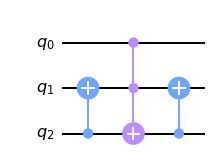

In [2]:
swap_circ = QuantumCircuit(3)
swap_circ.cswap(0, 1, 2)
swap_circ.decompose().draw(output='mpl')

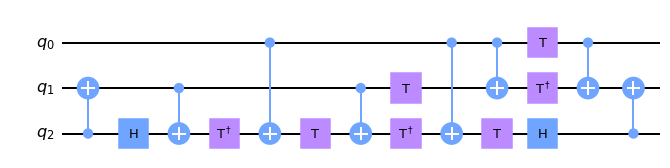

In [3]:
swap_circ = QuantumCircuit(3)
swap_circ.cnot(2, 1)
swap_circ.ccx(0, 1, 2)
swap_circ.cnot(2, 1)
swap_circ.decompose().draw(output='mpl')

### So you need 8 CNOTs to perform one CSWAP instruction.
### If you way to swap an arbitrary state |\Psi> and |\Phi> each with $L$ qubits, then you'll need $O(n)$ CSWAPs
### So you'll need $\leq 8L$ CNOTs to perform the controlled swap between the two states

------------------

### For integrable model there are $L$ Heisenberg terms. So we need $L$ $N$ circuits, below.
### Each $N$ circuit has 3 CNOTs and 8 gates total.
### Thus total number of CNOTs needed for one Trotter/Ansatz step is $L \times 3$, and the total number of gates is $L\times 8$ (ignoring initialization and ending swaps)

In [11]:
L = 4

def TrotterEvolveCircuit(dt, nt, init):
    """
    Implements trotter evolution of the Heisenberg hamiltonian using the circuit from https://arxiv.org/pdf/1906.06343.pdf
    :param tf: time to evolve to
    :param nt: number of trotter steps to use
    :param init: initial state for the trotter evolution. Should be another Qiskit circuit
    """

    # def get_angles(a, b, c):
    #     return (np.pi/2 - 2*c, 2*a - np.pi/2, np.pi/2 - 2*b)
    def get_angles(a):
        return (np.pi/2 - 2*a, 2*a - np.pi/2, np.pi/2 - 2*a)

    def N(circ, qb0, qb1):
        circ.rz(-np.pi/2, qb1)
        circ.cnot(qb1, qb0)
        circ.rz(theta, qb0)
        circ.ry(phi, qb1)
        circ.cnot(qb0, qb1)
        circ.ry(lambd, qb1)
        circ.cnot(qb1, qb0)
        circ.rz(np.pi/2, qb0)
        return circ

    theta, phi, lambd = get_angles(-dt/4)
    circ = init

    for i in range(nt):
        # even (odd indices)
        if (L % 2 == 0):
            # UEven
            for i in range(1, L, 2):
                circ = N(circ, i, (i+1)%L)
            # UOdd
            for i in range(0, L-1, 2):
                circ = N(circ, i, (i+1)%L)
        else:
            # UEven
            for i in range(1, L, 2):
                circ = N(circ, i, (i+1)%L)
            # UOdd
            for i in range(0, L-1, 2):
                circ = N(circ, i, (i+1)%L)
            # UBdy
            circ = N(circ, L-1, 0)
    
    return circ

def AnsatzCircuit(params, p):
    """

    """
    circ = QuantumCircuit(L)

    def get_angles(a):
        return (np.pi/2 - 2*a, 2*a - np.pi/2, np.pi/2 - 2*a)

    def N(cir, angles, qb0, qb1):
        cir.rz(-np.pi/2, qb1)
        cir.cnot(qb1, qb0)
        cir.rz(angles[0], qb0)
        cir.ry(angles[1], qb1)
        cir.cnot(qb0, qb1)
        cir.ry(angles[2], qb1)
        cir.cnot(qb1, qb0)
        cir.rz(np.pi/2, qb0)
        return cir

    for i in range(p):
        if (L % 2 == 0):
            for j in range(1, L, 2):
                circ = N(circ, get_angles(-params[(L*i)+j]/4), j, (j+1)%L)
            for j in range(0, L-1, 2):
                circ = N(circ, get_angles(-params[(L*i)+j]/4), j, (j+1)%L)
        else:
            for j in range(1, L, 2):
                circ = N(circ, get_angles(-params[(L*i)+j]/4), j, (j+1)%L)
            for j in range(0, L-1, 2):
                circ = N(circ, get_angles(-params[(L*i)+j]/4), j, (j+1)%L)
            circ = N(circ, get_angles(-params[(L*i)+L-1]/4), L-1, 0)
    
    return circ

def ReorderBasis(circ):
    """
    Reorders basis so that 0th qubit is on the left side of the tensor product
    :param circ: circuit to reorder, can also be a vector
    """
    if (isinstance(circ, qiskit.circuit.quantumcircuit.QuantumCircuit)):
        for i in range(L//2):
            circ.swap(i, L-i-1)
        return circ
    else:
        perm = np.eye(2**L)
        for i in range(1, 2**L//2-1):
            perm[:, [i, 2**L-i-1]] = perm[:, [2**L-i-1, i]]
        return perm @ circ

def SimulateAndReorder(circ):
    """
    Executes a circuit using the statevector simulator and reorders basis to match with standard
    """
    circ = ReorderBasis(circ)
    backend = Aer.get_backend('statevector_simulator')
    return execute(circ, backend).result().get_statevector()

def Simulate(circ):
    """
    Executes a circuit using the statevector simulator. Doesn't reorder -- which is needed for intermediate steps in the VTC
    """
    backend = Aer.get_backend('statevector_simulator')
    return execute(circ, backend).result().get_statevector()

def LoschmidtEcho(params, U_v, U_trot, init, p, shots):
    """
    Cost function using the Loschmidt Echo. Just using statevectors currently -- can rewrite using shots
    :param params: parameters new variational circuit that represents U_trot U_v | init >. Need dagger for cost function
    :param U_v: variational circuit that stores the state before the trotter step
    :param U_trot: trotter step
    :param init: initial state
    :param p: number of ansatz steps
    """
    U_v_prime = AnsatzCircuit(params, p)
    circ = init + U_v + U_trot + U_v_prime.inverse()
    circ.measure_all()

    c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
    c = ''.join(c)[::-1]

    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(circ, backend_sim, shots=shots)
    res = job_sim.result().get_counts()

    return 1 - (res.get(c)/shots)
    # loschmidt = Simulate(circ)
    # init = Simulate(init)
    # return 1 - abs(np.conj(init) @ loschmidt)**2

def SwapTest(params, U_v, U_trot, init, p, shots):
    """
    Cost function using the swap test. 
    :param params: parameters new variational circuit that represents U_trot U_v | init >. Need dagger for cost function
    :param U_v: variational circuit that stores the state before the trotter step
    :param U_trot: trotter step
    :param init: initial state
    :param p: number of ansatz steps
    :param shots: number of measurements to take
    """
    U_v_prime = init + AnsatzCircuit(params, p)
    U_v_prime = U_v_prime.qasm()
    U_v_prime = U_v_prime.replace(f'q[{L}]', f'q[{2*L+1}]')

    for i in range(L, -1, -1):
        U_v_prime = U_v_prime.replace(f'q[{i}]', f'q[{i+1}]')
    U_v_prime = circuit.QuantumCircuit.from_qasm_str(U_v_prime)

    comp = init + U_v + U_trot
    comp = comp.qasm()
    comp = comp.replace(f'q[{L}]', f'q[{2*L+1}]')
    for i in range(L, -1, -1):
        comp = comp.replace(f'q[{i}]', f'q[{L+i+1}]')
    comp = circuit.QuantumCircuit.from_qasm_str(comp)

    circ = QuantumCircuit(2*L+1, 1)
    circ.h(0)
    circ += U_v_prime 
    circ += comp

    # controlled swaps
    for i in range(L):
        circ.cswap(0, i+1, L+i+1)
    circ.h(0)
    circ.measure(0,0)
    
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(circ, backend_sim, shots=shots)
    res = job_sim.result().get_counts()

    # if (res.get('1') is None):
        # return 0
    # else:
    return 1 - (res.get('0')/shots)

def VTC(tf, dt, p, init):
    """
    :param init: initial state as a circuit
    """
    nt = int(np.ceil(tf / (dt * p)))

    VTCParamList = []
    VTCStepList = [Simulate(init)]
    TimeStep = [0]

    for i in range(nt):
        print(i)
        if (i == 0):
            U_v = QuantumCircuit(L)
        else:
            U_v = AnsatzCircuit(VTCParamList[-1], p)
        U_trot = TrotterEvolveCircuit(dt, p, QuantumCircuit(L))
        
        init_params = np.random.uniform(0, np.pi, L*p)
        # res = minimize(fun=LoschmidtEcho, x0=init_params, args=(U_v, U_trot, init, p))
        res = minimize(fun=SwapTest, x0=init_params, args=(U_v, U_trot, init, p, 2048), method='Powell')

        VTCParamList.append(res.x)
        VTCStepList.append(Simulate(init + AnsatzCircuit(res.x, p)))
        TimeStep.append(TimeStep[-1]+(dt*p))

    VTCStepList = [ReorderBasis(VTCStepList[i]) for i in range(len(VTCStepList))]

    VTCParamList = pd.DataFrame(np.array(VTCParamList), index=np.array(TimeStep[1:]))
    VTCStepList = pd.DataFrame(np.array(VTCStepList), index=np.array(TimeStep))

    VTCStepList.to_csv(f'./VTD_results/VTD_results_{tf}_{L}_{p}_{dt}.csv')


In [6]:
p = 3
init = QuantumCircuit(L)
c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
for q in range(len(c)):
    if (c[q] == '1'):
        init.x(q)

# VTC(5, 0.5, p, init)


In [14]:
U_v = QuantumCircuit(L)
U_trot = TrotterEvolveCircuit(0.5, 1, QuantumCircuit(L))
# U_trot = QuantumCircuit(L)
# Simulate(trot)
init_params = np.random.uniform(0, np.pi, L*p)
res = minimize(fun=LoschmidtEcho, x0=init_params, args=(U_v, U_trot, init, p, 2048), method='COBYLA')
# res = minimize(fun=SwapTest, x0=init_params, args=(U_v, U_trot, init, p, 2048), method='COBYLA')

res

     fun: 0.0517578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 124
  status: 1
 success: True
       x: array([3.03747105, 1.88889288, 3.58669434, 3.691412  , 1.80539733,
       0.30385842, 2.46227837, 1.47628569, 1.14032733, 3.35119752,
       1.92494852, 2.55329617])

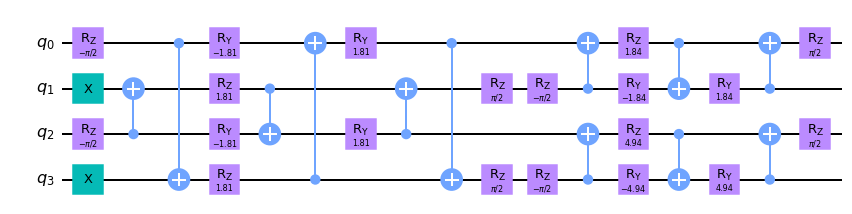

In [93]:
trot = init + U_trot
ansz = init + AnsatzCircuit(res.x, p)
ansz.draw(output='mpl')

In [94]:
backend = Aer.get_backend('statevector_simulator')
trot_vec = execute(trot, backend).result().get_statevector()
ansz_vec = execute(ansz, backend).result().get_statevector()
init_vec = execute(init, backend).result().get_statevector()
print(abs(np.conj(trot_vec) @ ansz_vec)**2)
print(abs(np.conj(init_vec) @ ansz_vec)**2)

0.9988620779532871
0.788050546649582


In [302]:
tf = 10
dt = 0.5
p = 1

p = 1
init = QuantumCircuit(L)
c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
for q in range(len(c)):
    if (c[q] == '1'):
        init.x(q)

perm = np.eye(2**L)
for i in range(1, 2**L//2-1):
    perm[:, [i, 2**L-i-1]] = perm[:, [2**L-i-1, i]]

nt = int(np.ceil(tf / (dt * p)))
VTCProgList = [init]
VTCStepList = [Simulate(VTCProgList[0])]
TimeStep = [0]

for i in range(nt):
    VTCProgList.append(TrotterEvolveCircuit(dt, p, VTCProgList[-1]))
    VTCStepList.append(Simulate(VTCProgList[-1]))
    TimeStep.append(TimeStep[-1]+(dt*p))

VTCStepList = [perm @ VTCStepList[i] for i in range(len(VTCStepList))]
VTCStepList = pd.DataFrame(np.array(VTCStepList), index=np.array(TimeStep))
VTCStepList.to_csv(f'./VTD_results/VTD_results_{tf}_{L}_{p}_{dt}.csv')